## <div style="text-align: center;"><b><span style='color:#e61227'>|</span> House Price Prediction EDA-XGBoost-Ridge-ANN<span style='color:#e61227'>|</span></b></div>

# <div style="color:white;display:fill;border-radius:8px;background-color:#03112A;font-size:150%;letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)"><p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>0. </span></b> Load the Necessary Libraries</b></p></div>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, probplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from joblib import parallel_backend
import re
import math

%matplotlib inline

In [2]:
import random
import tensorflow as tf

# Set random seed for NumPy
np.random.seed(54753)
# Set random seed for Python random module
random.seed(32345)
# Set random seed for TensorFlow
tf.random.set_seed(8645)

## <div style="color:white;display:fill;border-radius:8px;background-color:#03112A;font-size:150%;letterspacing:1.0px;background-image:url(https://i.imgur.com/GVd0La1.png)"><p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>1. </span></b> Read the Dataframe</b></p></div>

In [3]:
from pathlib import Path

df_train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
df_test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [4]:
print(df_train.shape)
print(df_test.shape)

(1460, 81)
(1459, 80)


In [5]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## <div style="color:white;display:fill;border-radius:8px;background-color:#03112A;font-size:150%;letterspacing:1.0px;background-image:url(https://i.imgur.com/GVd0La1.png)"><p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>2. </span></b> Data Cleaning</b></p></div>

In [7]:
null_df = pd.DataFrame(columns=["Features", "Null %"])
null_df["Features"] = df_train.columns
null_df["Null %"] = np.round(df_train.isnull().sum().values/df_train.shape[0], 4).reshape(-1)
null_df.sort_values(by = "Null %", ascending=False)

,Features,Null %
72,PoolQC,0.9952
74,MiscFeature,0.9630
6,Alley,0.9377
73,Fence,0.8075
25,MasVnrType,0.5973
...,...,...
27,ExterQual,0.0000
24,Exterior2nd,0.0000
23,Exterior1st,0.0000
22,RoofMatl,0.0000


In [8]:
# Filter columns in df_train and df_test based on null percentage
threshold = 0.10  # Set the threshold for null percentage

null_columns = (null_df.iloc[:-1, 1] < threshold).index

y = df_train["SalePrice"]
df_train = df_train.iloc[:, null_columns]
df_test = df_test.iloc[:, null_columns]


In [9]:
# Fill missing values with mode for both numeric and categorical columns
mode_values = df_train.mode().iloc[0]
df_train.fillna(mode_values, inplace=True)
df_test.fillna(mode_values, inplace=True)

In [10]:
df_train.isnull().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 80, dtype: int64

In [11]:
df_train.shape

(1460, 80)

In [12]:
# all missing rows
df_train.isnull().any(axis = 1).sum()

0

In [13]:
df_train = df_train[~df_train.isnull().any(axis = 1)].reset_index(drop = True)
df_test = df_test[~df_test.isnull().any(axis = 1)].reset_index(drop = True)

df_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,Grvl,Reg,Lvl,AllPub,...,0,0,Gd,MnPrv,Shed,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,Grvl,Reg,Lvl,AllPub,...,0,0,Gd,MnPrv,Shed,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,Grvl,IR1,Lvl,AllPub,...,0,0,Gd,MnPrv,Shed,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,Grvl,IR1,Lvl,AllPub,...,0,0,Gd,MnPrv,Shed,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,Grvl,IR1,Lvl,AllPub,...,0,0,Gd,MnPrv,Shed,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Grvl,Reg,Lvl,AllPub,...,0,0,Gd,MnPrv,Shed,0,8,2007,WD,Normal
1456,1457,20,RL,85.0,13175,Pave,Grvl,Reg,Lvl,AllPub,...,0,0,Gd,MnPrv,Shed,0,2,2010,WD,Normal
1457,1458,70,RL,66.0,9042,Pave,Grvl,Reg,Lvl,AllPub,...,0,0,Gd,GdPrv,Shed,2500,5,2010,WD,Normal
1458,1459,20,RL,68.0,9717,Pave,Grvl,Reg,Lvl,AllPub,...,0,0,Gd,MnPrv,Shed,0,4,2010,WD,Normal


### Check for special characters

In [14]:
# Create a mask to identify rows with special characters in the 'city' column
cat_cols = df_train.select_dtypes(include = [object])

mask = []
for col in cat_cols.columns:
    mask.append(df_train[col].str.contains(r'[^\x00-\x7F]', regex=True).sum())

mask

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [15]:
cols_ToBe_del = ["Id"]
df_Id = df_test["Id"].reset_index(name="Id")

df_train = df_train.drop(columns = cols_ToBe_del, axis = 1)
df_test = df_test.drop(columns = cols_ToBe_del, axis = 1)

## <div style="color:white;display:fill;border-radius:8px;background-color:#03112A;font-size:150%;letterspacing:1.0px;background-image:url(https://i.imgur.com/GVd0La1.png)"><p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>3. </span></b> Exploratory Data Analysis</b></p></div>

In [16]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_features = list(df_train.select_dtypes(numerics).columns)

/tmp/ipykernel_19/4018310785.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["SalePrice"] = y.values


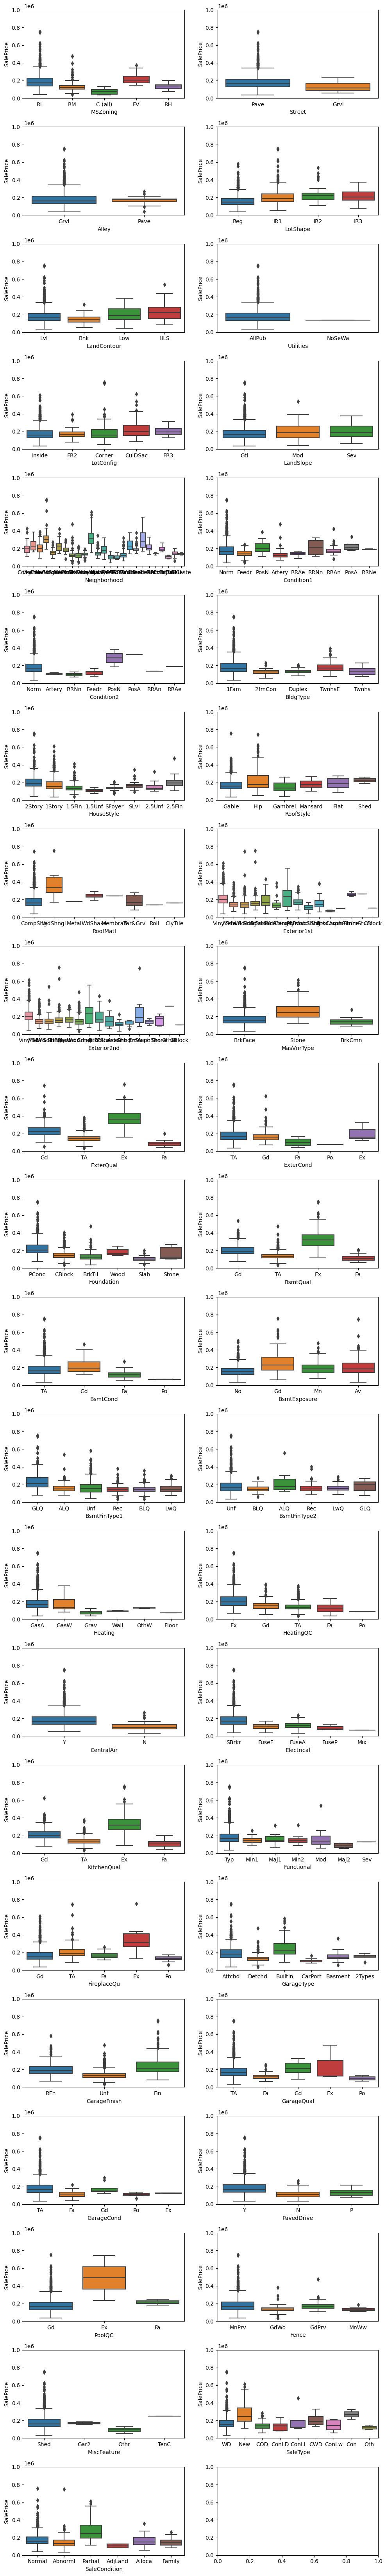

In [17]:
cat_cols = list(df_train.select_dtypes(include = [object]).columns)
num_cols = list(df_train.select_dtypes(include = numerics).columns)

df_temp = df_train[cat_cols]
df_temp["SalePrice"] = y.values

n_cols = 2
n_rows = math.ceil(len(cat_cols)/n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3*n_rows))

for i, var in enumerate(cat_cols):
    
    row = i // n_cols
    col = i % n_cols
    
    data = pd.concat([df_temp["SalePrice"], df_temp[var]], axis=1)
    sns.boxplot(x=var, y="SalePrice", data=data, ax=axes[row, col])
    axes[row, col].set_ylim(0, 1000000)  # Set y-axis limits
    
plt.tight_layout()
plt.show()

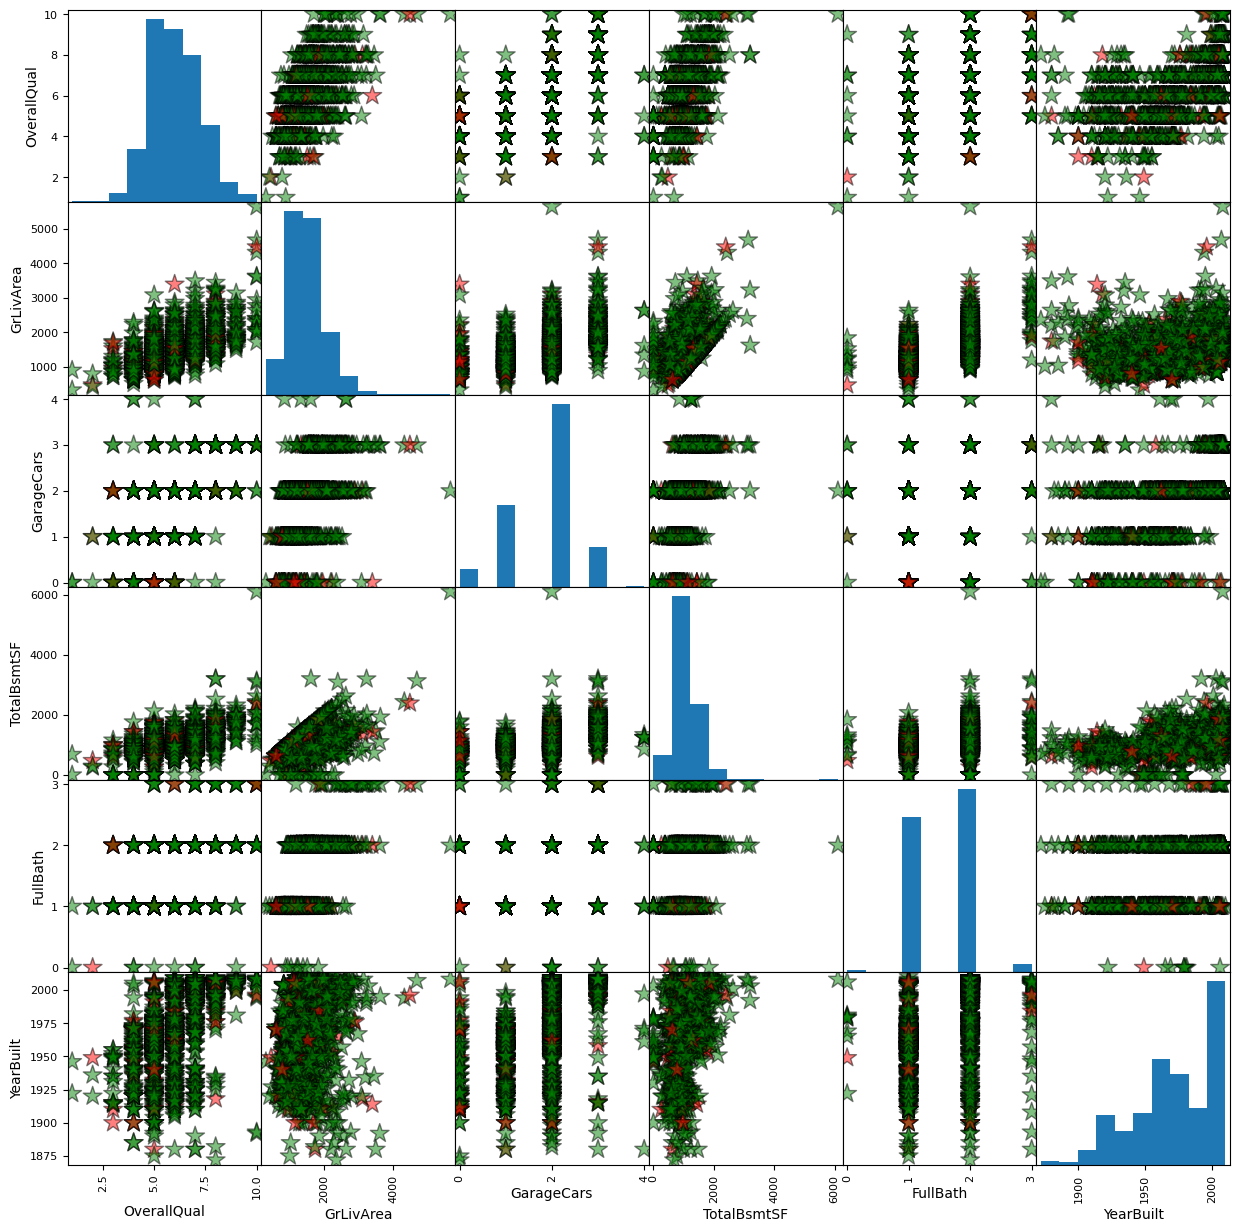

In [18]:
pairplot_cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']

df_temp = df_train[pairplot_cols+["SaleCondition"]]

color_list = ['red' if i=='Abnorml' else 'green' for i in df_temp.loc[:,'SaleCondition']]
pd.plotting.scatter_matrix(df_temp.loc[:, df_temp.columns != 'SaleCondition'],
                                       c=color_list,
                                       figsize= [15,15],
                                       diagonal='hist',
                                       alpha=0.5,
                                       s = 200,
                                       marker = '*',
                                       edgecolor= "black")
plt.show()

#### Skew and Kurtosis
Skewness measures the asymmetry of a distribution. A positive skew indicates a right-skewed distribution (tail to the right), while a negative skew indicates a left-skewed distribution (tail to the left). Extreme skewness values (far from 0) might suggest the presence of outliers, especially if the distribution is not expected to be skewed.

In [19]:
# We now use skew to check for the symmetry of the data distribution (0 being perfectly symmetrical)
for col in num_features:
    print('The kurtosis for {} is: {}'.format(col, df_train[col].skew()))

The kurtosis for MSSubClass is: 1.4076567471495591
The kurtosis for LotFrontage is: 2.5040916462700338
The kurtosis for LotArea is: 12.207687851233496
The kurtosis for OverallQual is: 0.2169439277628693
The kurtosis for OverallCond is: 0.6930674724842182
The kurtosis for YearBuilt is: -0.613461172488183
The kurtosis for YearRemodAdd is: -0.5035620027004709
The kurtosis for MasVnrArea is: 2.6776164510820997
The kurtosis for BsmtFinSF1 is: 1.685503071910789
The kurtosis for BsmtFinSF2 is: 4.255261108933303
The kurtosis for BsmtUnfSF is: 0.9202684528039037
The kurtosis for TotalBsmtSF is: 1.5242545490627664
The kurtosis for 1stFlrSF is: 1.3767566220336365
The kurtosis for 2ndFlrSF is: 0.8130298163023265
The kurtosis for LowQualFinSF is: 9.011341288465387
The kurtosis for GrLivArea is: 1.3665603560164552
The kurtosis for BsmtFullBath is: 0.596066609663168
The kurtosis for BsmtHalfBath is: 4.103402697955168
The kurtosis for FullBath is: 0.036561558402727165
The kurtosis for HalfBath is: 0.6

In [20]:
# We also could use kurtosis. “Kurtosis is the degree of peakedness of a distribution” – Wolfram MathWorld

for col in num_features:
    print('The skewness for {} is: {}'.format(col, df_train[col].kurtosis()))

The skewness for MSSubClass is: 1.5801879649863309
The skewness for LotFrontage is: 21.172817512915437
The skewness for LotArea is: 203.24327101886033
The skewness for OverallQual is: 0.09629277835615113
The skewness for OverallCond is: 1.1064134613731684
The skewness for YearBuilt is: -0.43955194159361977
The skewness for YearRemodAdd is: -1.2722451924732956
The skewness for MasVnrArea is: 10.141416177298794
The skewness for BsmtFinSF1 is: 11.118236291964712
The skewness for BsmtFinSF2 is: 20.11333754558646
The skewness for BsmtUnfSF is: 0.47499398780908475
The skewness for TotalBsmtSF is: 13.250483281984796
The skewness for 1stFlrSF is: 5.74584148244079
The skewness for 2ndFlrSF is: -0.5534635576075795
The skewness for LowQualFinSF is: 83.2348166744174
The skewness for GrLivArea is: 4.895120580693174
The skewness for BsmtFullBath is: -0.8390982654634271
The skewness for BsmtHalfBath is: 16.396641945350446
The skewness for FullBath is: -0.8570428212743262
The skewness for HalfBath is:

In [21]:
df_train[num_features].describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,68.267123,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,46.549315,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,42.300571,22.356355,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,161.319273,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,63.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [22]:
## So in order to remove or filter out our high value 'outliers' let's consider taking our data from the 99.5% percentile and exclude the bottom .25% and top 0.25% of prices
## This function returns the highest value of the 99.5% percentile which is still relatively high when compared to the mean and median

for col in num_features:
    print('The the 99.5% percentile for {} is: {}'.format(col, df_train[col].quantile(0.995)))

The the 99.5% percentile for MSSubClass is: 190.0
The the 99.5% percentile for LotFrontage is: 152.70499999999993
The the 99.5% percentile for LotArea is: 53422.28499999998
The the 99.5% percentile for OverallQual is: 10.0
The the 99.5% percentile for OverallCond is: 9.0
The the 99.5% percentile for YearBuilt is: 2009.0
The the 99.5% percentile for YearRemodAdd is: 2009.0
The the 99.5% percentile for MasVnrArea is: 959.3649999999961
The the 99.5% percentile for BsmtFinSF1 is: 1753.4299999999967
The the 99.5% percentile for BsmtFinSF2 is: 1049.329999999998
The the 99.5% percentile for BsmtUnfSF is: 1932.3449999999993
The the 99.5% percentile for TotalBsmtSF is: 2429.8399999999965
The the 99.5% percentile for 1stFlrSF is: 2434.2649999999976
The the 99.5% percentile for 2ndFlrSF is: 1533.574999999999
The the 99.5% percentile for LowQualFinSF is: 457.36499999999614
The the 99.5% percentile for GrLivArea is: 3431.659999999996
The the 99.5% percentile for BsmtFullBath is: 2.0
The the 99.5% p

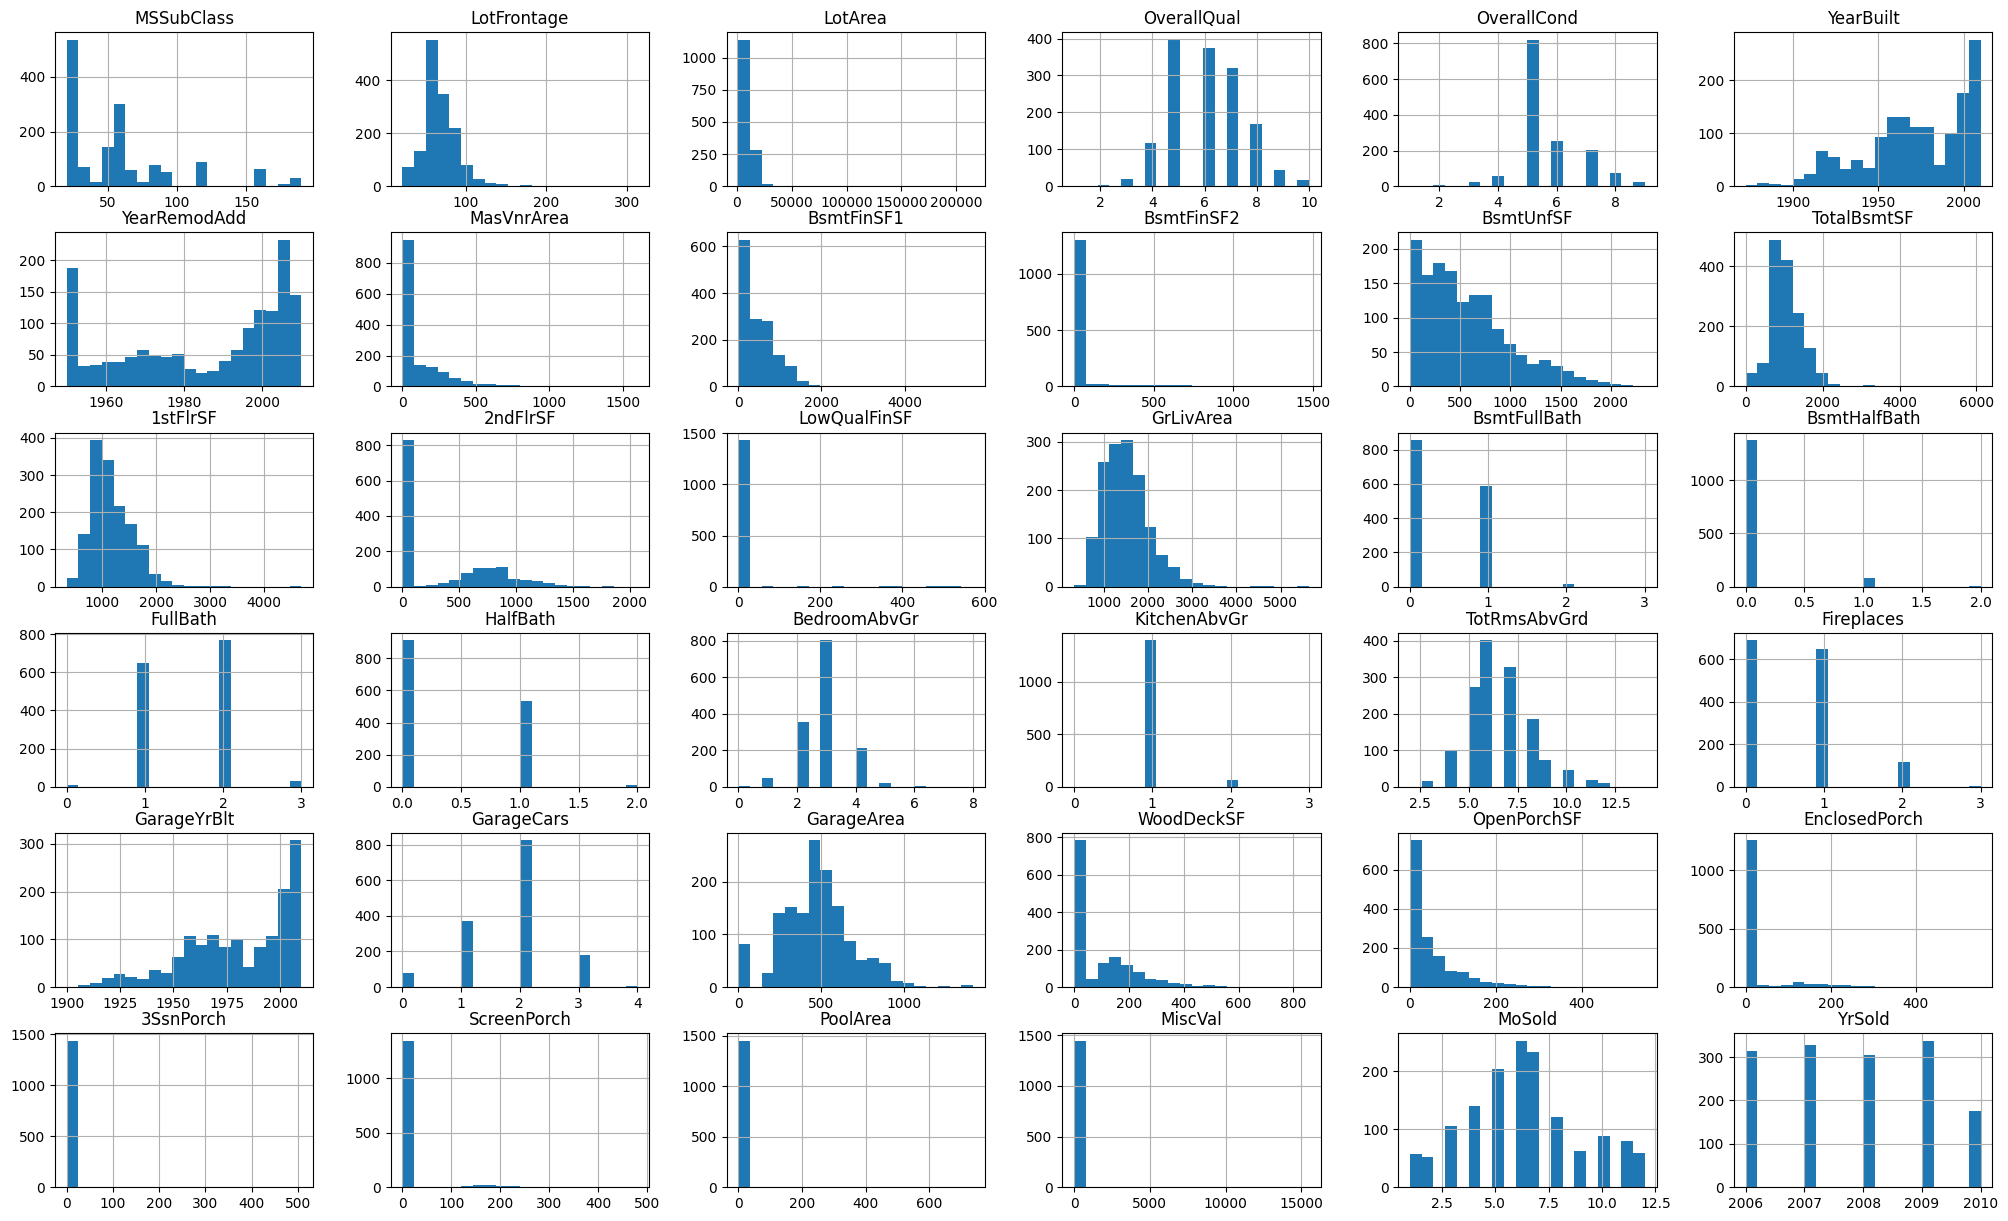

In [23]:
df_train[num_features].hist(bins = 20, figsize = (25, 15))
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


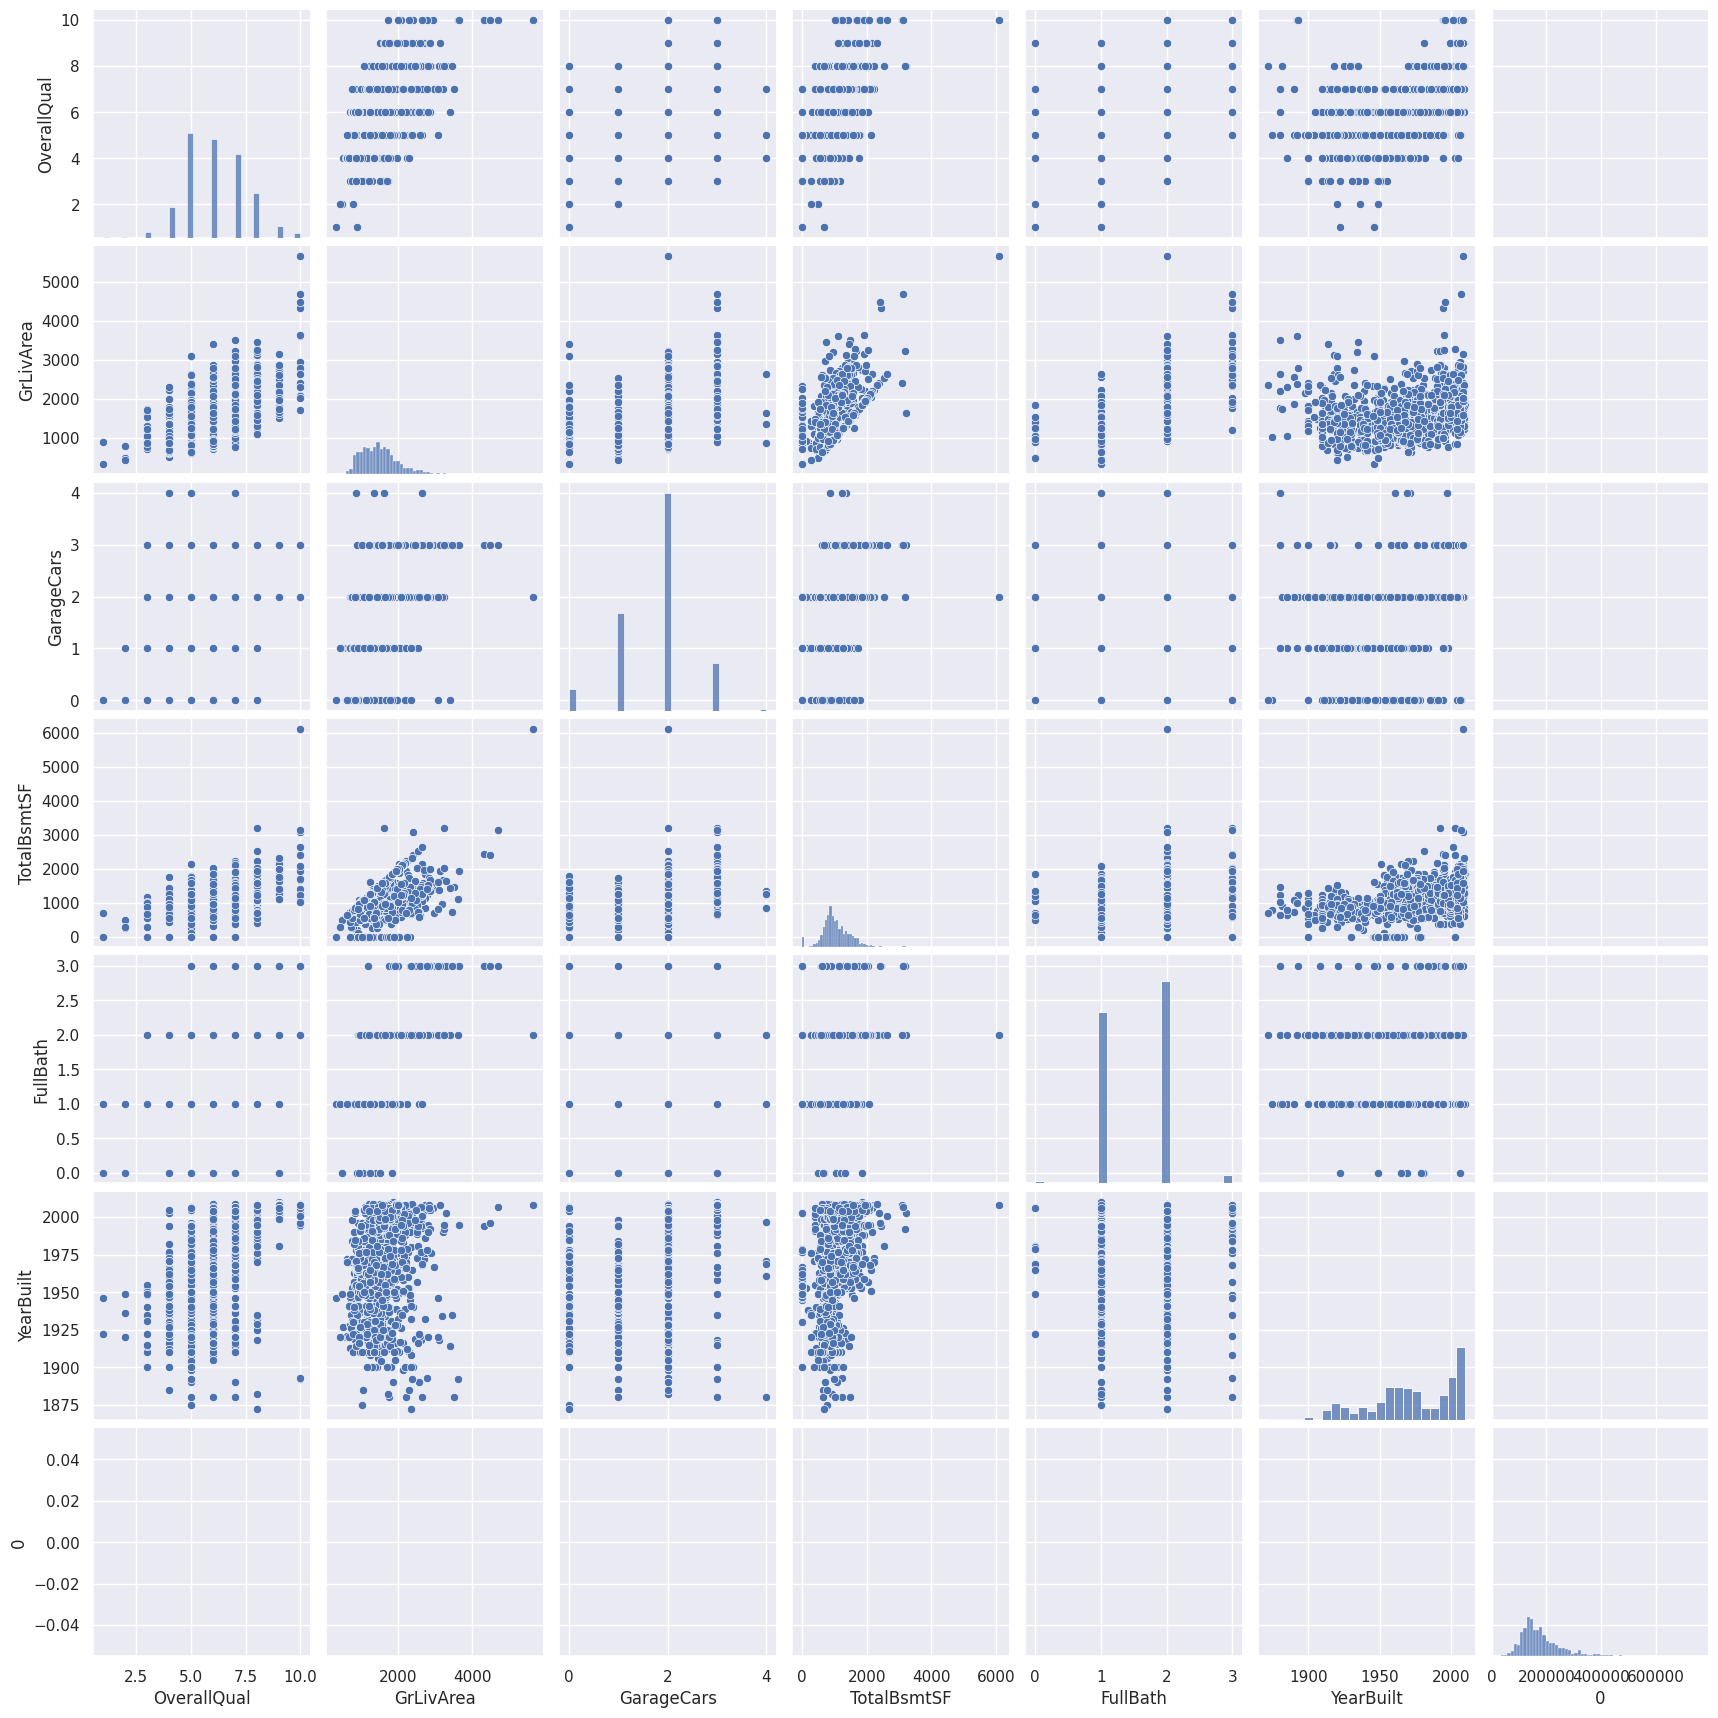

In [24]:
# scatterplot
sns.set()
sns.pairplot(pd.concat([df_train[pairplot_cols], y]), size = 2.5)
plt.show()

/tmp/ipykernel_19/2018030330.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, fit=norm);


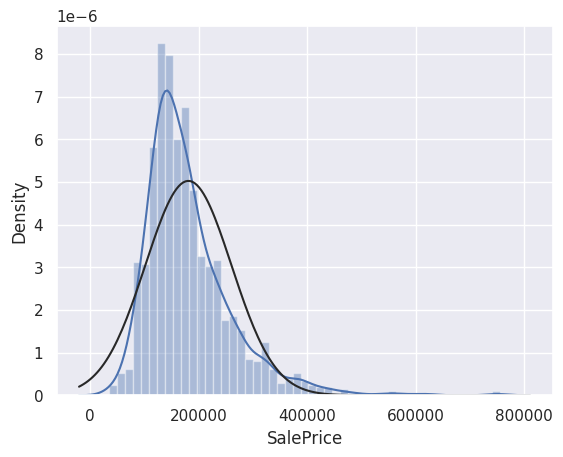

In [25]:
#transformed histogram and normal probability plot
sns.distplot(y, fit=norm);
# fig = plt.figure()
# res = stats.probplot(y, plot=plt)

/tmp/ipykernel_19/353830106.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Xy['SalePrice'] = y.values


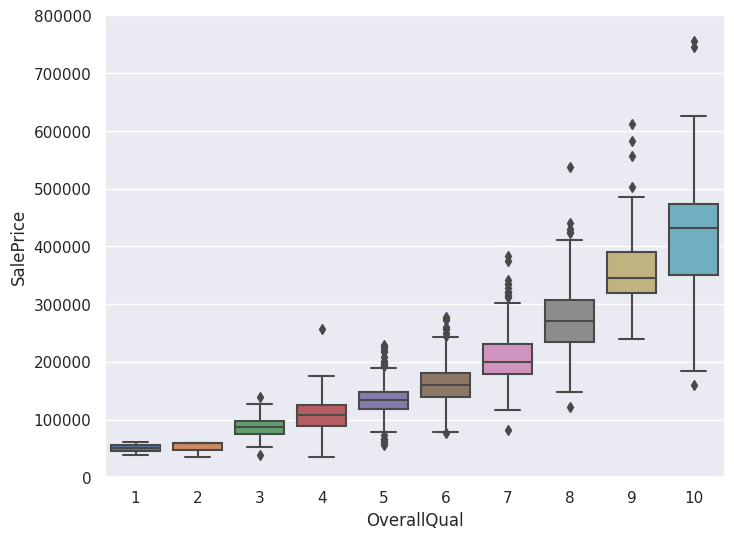

In [26]:
# boxplot for overallqual vs. saleprice

df_Xy = df_train[pairplot_cols]
df_Xy['SalePrice'] = y.values

f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='OverallQual', y="SalePrice", data=df_Xy)
fig.axis(ymin=0, ymax=800000);

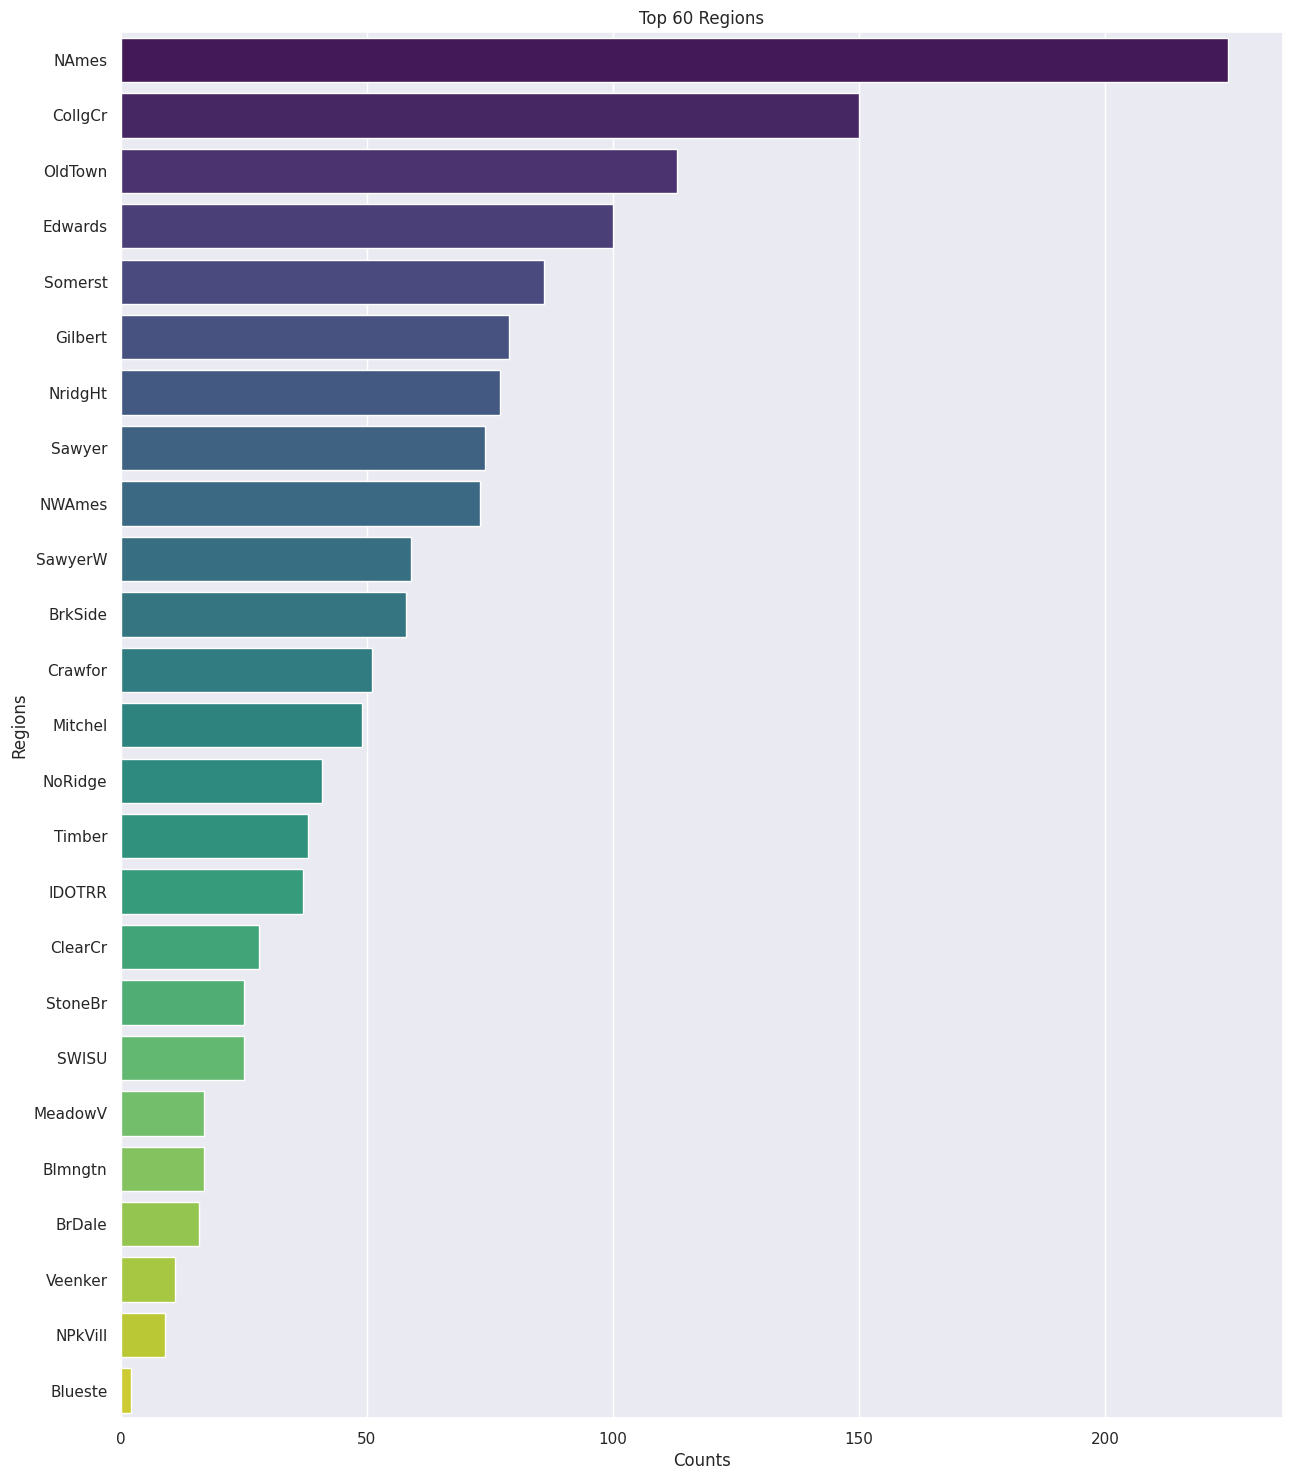

In [27]:
top60_locs = df_train["Neighborhood"].value_counts().head(60)

plt.figure(figsize = (15, 18))
sns.barplot(x = top60_locs.values, y = top60_locs.index, palette = "viridis")
plt.xlabel("Counts")
plt.ylabel("Regions")
plt.title("Top 60 Regions")
plt.show()

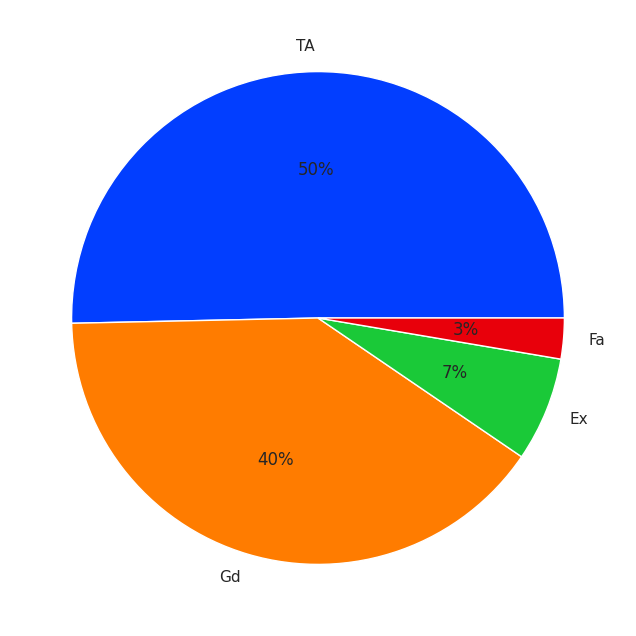

In [28]:
KitchenQual_options = df_train["KitchenQual"].value_counts()

plt.figure(figsize = (8, 8))
# define Seaborn color palette to use 
palette_color = sns.color_palette('bright') 


# plotting data on chart 
plt.pie(KitchenQual_options.values, labels=KitchenQual_options.index, colors=palette_color, autopct='%.0f%%') 

plt.show()

## <div style="color:white;display:fill;border-radius:8px;background-color:#03112A;font-size:150%;letterspacing:1.0px;background-image:url(https://i.imgur.com/GVd0La1.png)"><p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>4. </span></b> Correlation Matrix</b></p></div>

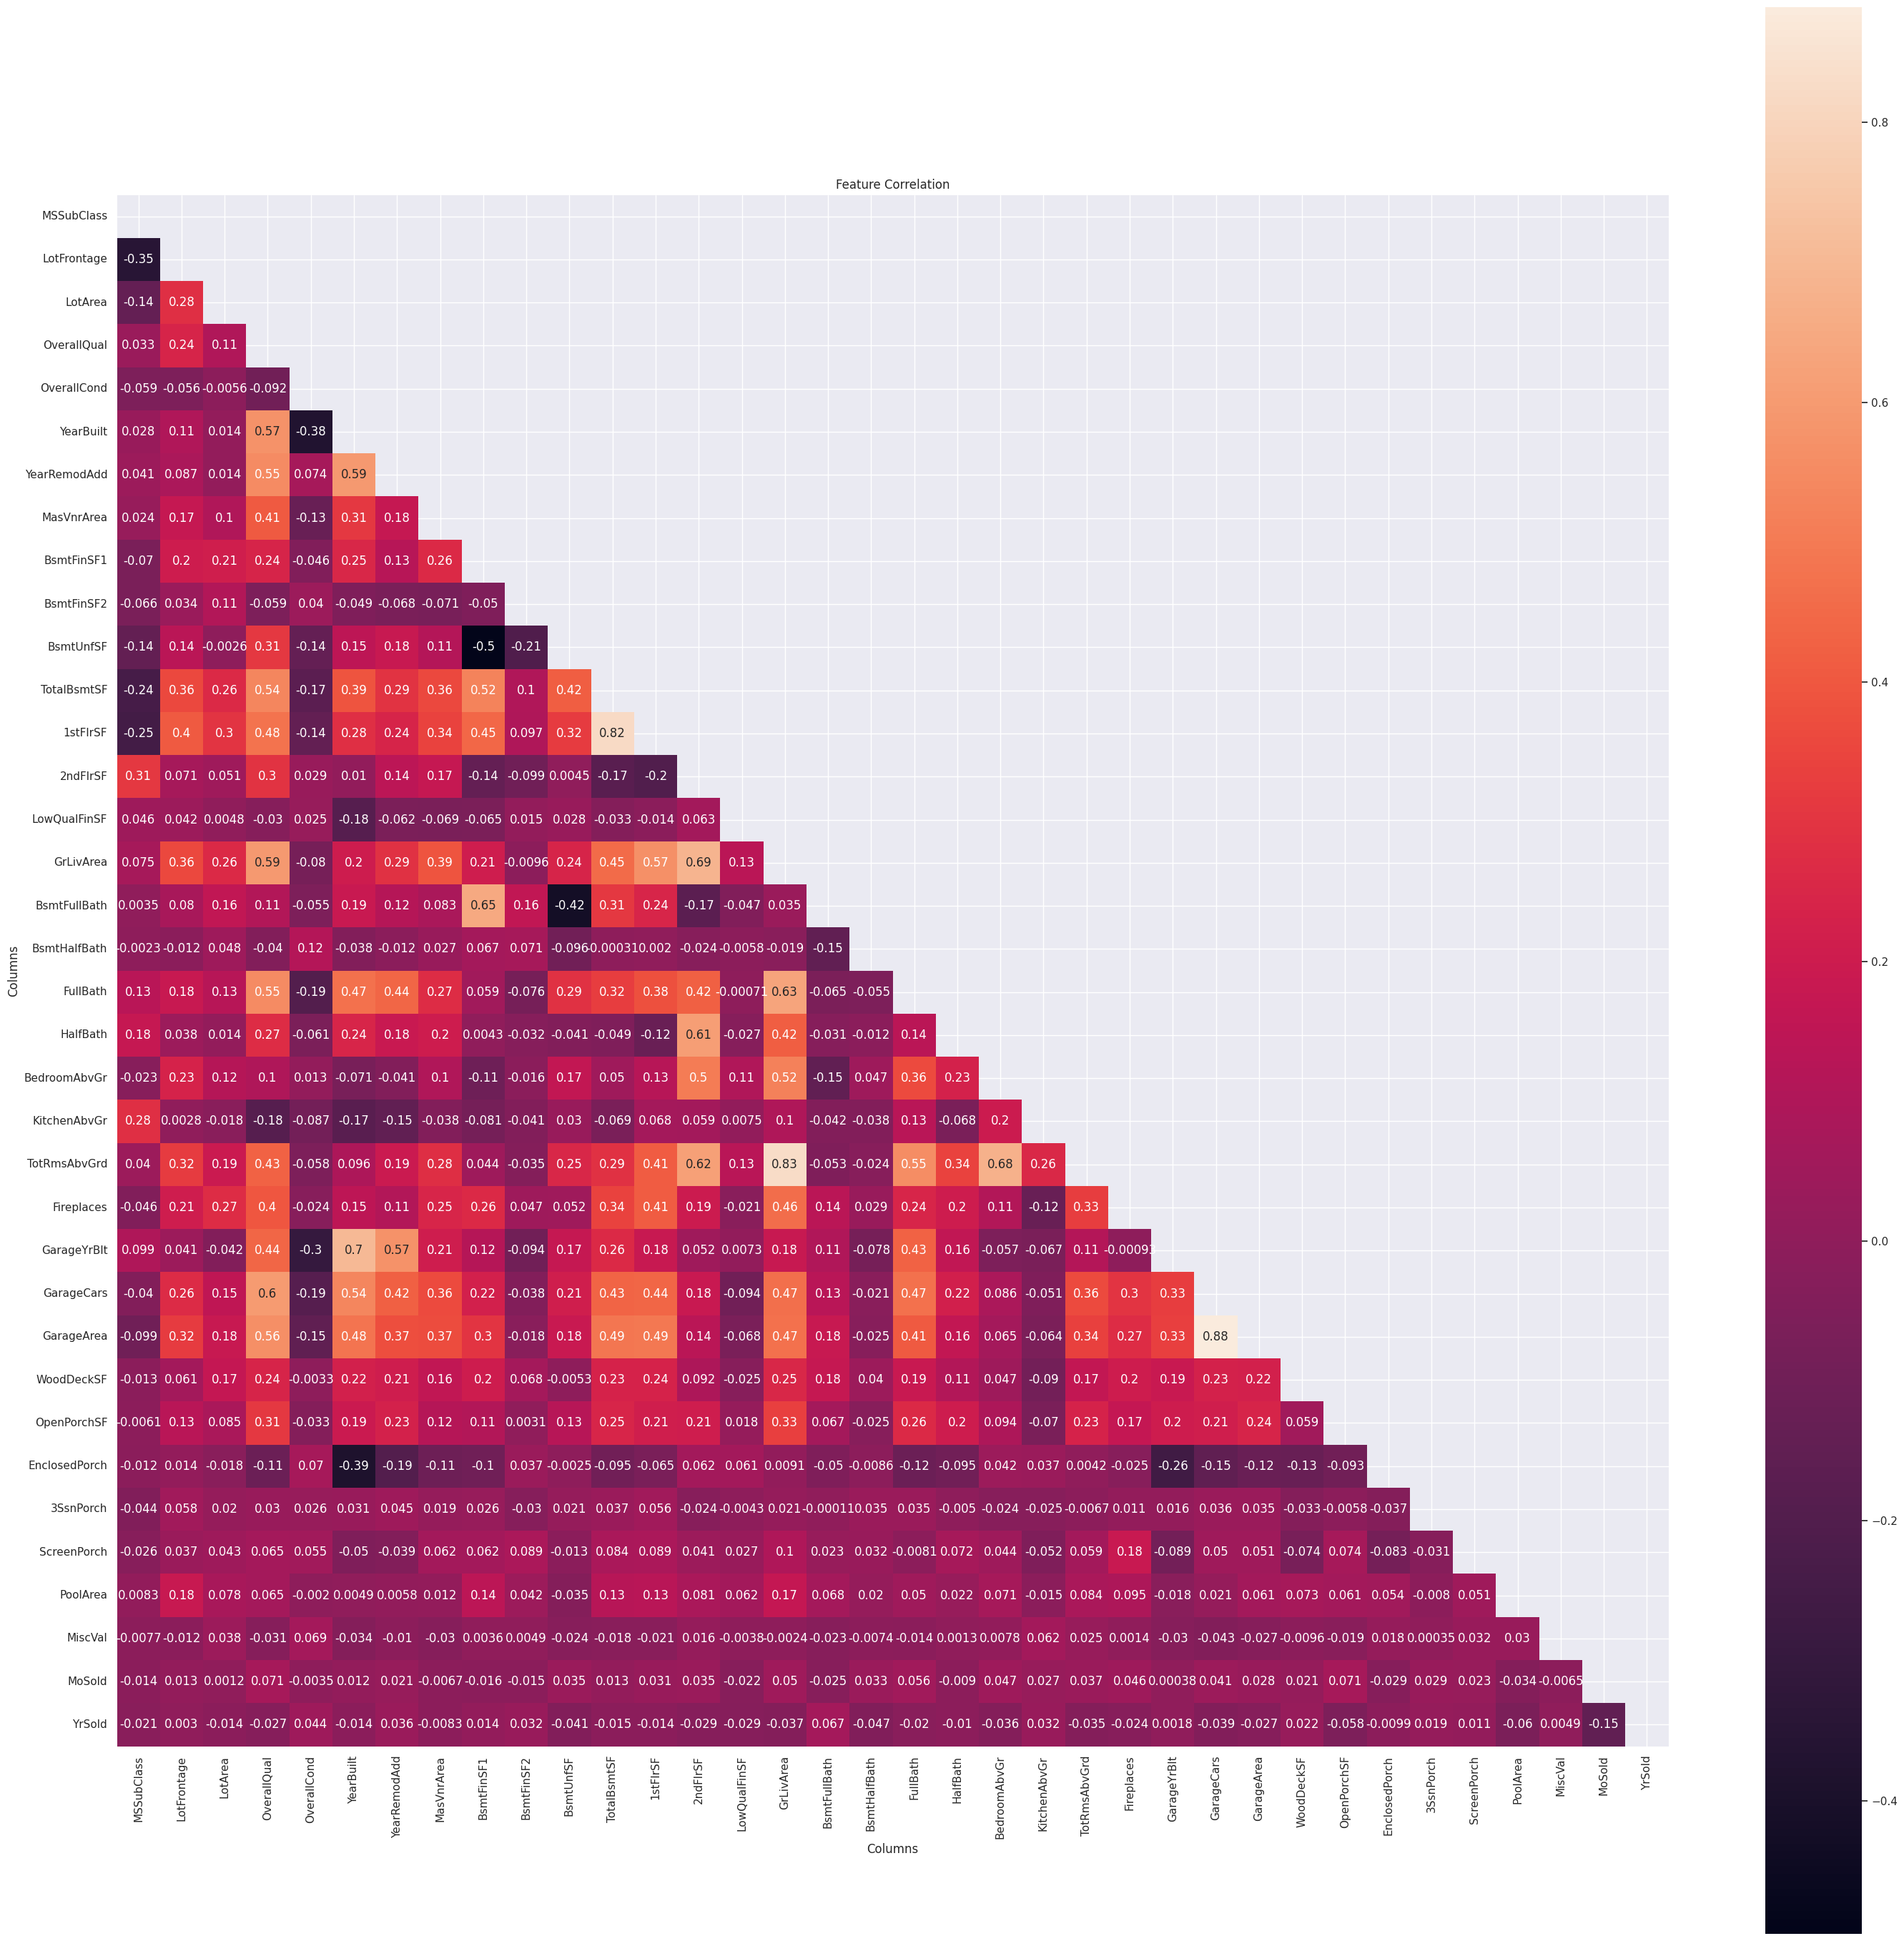

In [29]:
corr_matrix = df_train.select_dtypes(include = numerics).corr()
mask = np.zeros_like(corr_matrix, dtype = bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize = (35, 35))

sns.heatmap(corr_matrix,
           annot = True,
           square = True,
           fmt = ".2g",
           mask = mask,
           ax = ax).set(
title = "Feature Correlation", xlabel = "Columns", ylabel = "Columns")

ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({"xtick.bottom": True}, {"ytick.bottom": True})

## <div style="color:white;display:fill;border-radius:8px;background-color:#03112A;font-size:150%;letterspacing:1.0px;background-image:url(https://i.imgur.com/GVd0La1.png)"><p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>5. </span></b> Feature Selection</b></p></div>

First, we can utilize a OLS model using statsmodels to gain insights into the statistical aspects of the model for feature selection. Later, we will transition to using the different algorithms.

In [30]:
import statsmodels.api as sm
from sklearn.preprocessing import OrdinalEncoder

# One-hot encode categorical variables
encoder = OrdinalEncoder()

encoded_cats = encoder.fit_transform(df_train[cat_cols])

# Create a DataFrame for the encoded categorical variables
encoded_df = pd.DataFrame(encoded_cats, columns=cat_cols)


# Concatenate encoded dataframe with other features
encoded_X = pd.concat([df_train[num_cols], encoded_df], axis=1)

# Add a constant term
encoded_X = sm.add_constant(encoded_X)

model = sm.OLS(y, encoded_X)
result_ols = model.fit()

result_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     106.9
Date:                Sat, 04 May 2024   Prob (F-statistic):               0.00
Time:                        18:50:16   Log-Likelihood:                -17128.
No. Observations:                1460   AIC:                         3.441e+04
Df Residuals:                    1382   BIC:                         3.482e+04
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.635e+06   1.29e+06      1.264      0.207   -9.03e+05    4.17e+06
MSSubClass     -102.7133     44.501     -2.308      0.021    -190.010     -15.417
LotFrontage    -146.4087     47.593     -3.076      0.002    -239.771     -53.046
LotArea           0.4078      0.104      3.926      0.000       0.204       0.612
OverallQual    1.056e+04   1162.594      9.081      0.000    8277.354    1.28e+04
OverallCond    5392.6852   1024.426      5.264      0.000    3383.088    7402.283
YearBuilt       172.7538     74.882      2.307      0.021      25.858     319.649
YearRemodAdd      5.7232     66.388      0.086      0.931    -124.509     135.955
MasVnrArea       27.6656      5.533      5.000      0.000      16.812      38.519
BsmtFinSF1        4.4531      2.832      1.572      0.116      -1.102      10.008
BsmtFinSF2        6.4353      5.898      1.091      0.275      -5.135      18.006
BsmtUnfSF        -3.6928      2.731     -1.352      0.177      -9.050       1.664
TotalBsmtSF       7.1956      3.489      2.062      0.039       0.351      14.040
1stFlrSF         24.2890      5.807      4.183      0.000      12.898      35.680
2ndFlrSF         21.6786      5.330      4.067      0.000      11.223      32.134
LowQualFinSF    -23.6345     13.779     -1.715      0.087     -50.665       3.396
GrLivArea        22.3332      5.399      4.137      0.000      11.742      32.924
BsmtFullBath   6629.6769   2406.372      2.755      0.006    1909.140    1.14e+04
BsmtHalfBath  -1448.7875   3779.872     -0.383      0.702   -8863.695    5966.120
FullBath       2984.0952   2634.143      1.133      0.257   -2183.256    8151.446
HalfBath       -414.6901   2479.522     -0.167      0.867   -5278.723    4449.343
BedroomAbvGr  -3723.3335   1627.920     -2.287      0.022   -6916.795    -529.872
KitchenAbvGr  -1.283e+04   4901.315     -2.618      0.009   -2.24e+04   -3218.046
TotRmsAbvGrd   3876.5831   1157.496      3.349      0.001    1605.945    6147.222
Fireplaces     6112.5607   1735.425      3.522      0.000    2708.209    9516.913
GarageYrBlt      70.7450     55.937      1.265      0.206     -38.986     180.476
GarageCars     1.083e+04   2690.464      4.025      0.000    5551.083    1.61e+04
GarageArea       -5.9005      9.167     -0.644      0.520     -23.884      12.083
WoodDeckSF       19.5580      7.364      2.656      0.008       5.113      34.004
OpenPorchSF      -4.6511     14.007     -0.332      0.740     -32.129      22.826
EnclosedPorch    -4.7167     15.337     -0.308      0.758     -34.804      25.371
3SsnPorch        27.3819     28.323      0.967      0.334     -28.178      82.942
ScreenPorch      47.5750     15.837      3.004      0.003      16.508      78.642
PoolArea       -170.1108     29.279     -5.810      0.000    -227.547    -112.675
MiscVal          -3.7620      2.736     -1.375   

In [31]:
# Perform feature selection using backward elimination
def backward_elimination(dataframe, dependent_variable):
    while True:
        dataframe = sm.add_constant(dataframe)
        model = sm.OLS(dependent_variable, dataframe)
        result_ols = model.fit()
        p_values = result_ols.pvalues[1:] # Exclude const
        max_p_value = p_values.max()
        if max_p_value < 0.05:
            
            break
        else:
            max_p_value_feature = p_values.idxmax()
            dataframe = dataframe.drop(columns=max_p_value_feature)
            
    return result_ols, dataframe

# Call backward_elimination function with your data
result, dataframe = backward_elimination(dataframe=encoded_X, dependent_variable=y)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     235.3
Date:                Sat, 04 May 2024   Prob (F-statistic):               0.00
Time:                        18:50:18   Log-Likelihood:                -17146.
No. Observations:                1460   AIC:                         3.436e+04
Df Residuals:                    1424   BIC:                         3.455e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -3.706e+05   9.45e+04     -3.924      0.000   -5.56e+05   -1.85e+05
MSSubClass     -100.0846     43.028     -2.326      0.020    -184.490     -15.679
LotFrontage    -143.6134     45.597     -3.150      0.002    -233.058     -54.169
LotArea           0.4359      0.094      4.660      0.000       0.252       0.619
OverallQual    1.057e+04   1120.838      9.433      0.000    8374.686    1.28e+04
OverallCond    5405.8457    846.626      6.385      0.000    3745.078    7066.613
YearBuilt       317.4400     45.997      6.901      0.000     227.210     407.670
MasVnrArea       27.2910      5.250      5.198      0.000      16.993      37.589
BsmtUnfSF        -8.6853      2.779     -3.126      0.002     -14.136      -3.234
TotalBsmtSF      11.6967      4.101      2.852      0.004       3.651      19.742
1stFlrSF         49.2275      5.201      9.465      0.000      39.025      59.430
2ndFlrSF         45.4439      3.864     11.762      0.000      37.865      53.023
BsmtFullBath   6526.1746   2194.198      2.974      0.003    2221.968    1.08e+04
BedroomAbvGr  -4102.2792   1552.563     -2.642      0.008   -7147.835   -1056.724
KitchenAbvGr  -1.127e+04   4596.410     -2.453      0.014   -2.03e+04   -2256.389
TotRmsAbvGrd   4004.0781   1098.516      3.645      0.000    1849.196    6158.961
Fireplaces     6206.3470   1654.192      3.752      0.000    2961.432    9451.262
GarageCars     9415.0045   1531.495      6.148      0.000    6410.777    1.24e+04
WoodDeckSF       19.2713      7.138      2.700      0.007       5.269      33.274
ScreenPorch      43.6311     15.132      2.883      0.004      13.948      73.315
PoolArea       -186.0023     28.187     -6.599      0.000    -241.295    -130.710
Street         3.369e+04   1.32e+04      2.549      0.011    7764.371    5.96e+04
Neighborhood    395.5072    142.309      2.779      0.006     116.349     674.666
Condition2    -8966.5154   3156.513     -2.841      0.005   -1.52e+04   -2774.602
BldgType      -3140.0038   1423.171     -2.206      0.028   -5931.741    -348.267
HouseStyle    -1279.8028    611.243     -2.094      0.036   -2478.835     -80.770
RoofMatl       5570.6441   1421.030      3.920      0.000    2783.107    8358.182
Exterior1st    -634.7719    267.448     -2.373      0.018   -1159.406    -110.138
ExterQual     -1.051e+04   1832.487     -5.737      0.000   -1.41e+04   -6917.434
BsmtQual      -9064.9391   1359.996     -6.665      0.000   -1.17e+04   -6397.129
BsmtExposure  -3743.9009    843.675     -4.438      0.000   -5398.880   -2088.921
KitchenQual   -8397.5411   1362.287     -6.164      0.000   -1.11e+04   -5725.237
Functional     3799.6022    895.265      4.244      0.000    2043.422    5555.782
FireplaceQu   -2229.2909   1029.011     -2.166      0.030   -4247.831    -210.751
PoolQC        -1.185e+05   1.37e+04     -8.671   

In [32]:
selected_cols = dataframe.columns
selected_cols = selected_cols[selected_cols != "const"]

In [33]:
X = pd.concat([df_train[selected_cols], df_test[selected_cols]], ignore_index=True)

In [34]:
# Update cat and num lists
cat_cols = list(X.select_dtypes(include = [object]).columns)
num_cols = list(X.select_dtypes(include = numerics).columns)

## <div style="color:white;display:fill;border-radius:8px;background-color:#03112A;font-size:150%;letterspacing:1.0px;background-image:url(https://i.imgur.com/GVd0La1.png)"><p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>6. </span></b> Pipeline: Feature Engineering</b></p></div>

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin

class AttributeAdder(BaseEstimator, TransformerMixin):
    def __init__(self, num_cols = []):
        self.num_cols = num_cols

    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        # Feature Engineering
        
        X = pd.DataFrame(X, columns = num_cols)
        
#         X["area_BedroomAbvGr"] = np.where(X["BedroomAbvGr"] != 0, X["LotArea"] / X["BedroomAbvGr"], 0)
        
        global feats
#         feats = ["area_BedroomAbvGr"]
        
        return X.values

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer



num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('attribute_adder', AttributeAdder(num_cols = num_cols)),
    ('standard_scaler', StandardScaler()),
])

In [37]:
from sklearn.compose import ColumnTransformer
import itertools


mid_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_cols),
        ("cat", OneHotEncoder(),cat_cols),
    ])

In [38]:
mid_pipeline.fit(X)
X = mid_pipeline.transform(X)

In [39]:
y = np.array(y).reshape(-1, 1)
scaler = StandardScaler()
y = scaler.fit_transform(y)

In [40]:
X = X.toarray()

X_train = X[:df_train.shape[0], :]

y_train = y.ravel() # reshape to 1D array like (100, ) not (100, 1)

X_test = X[X_train.shape[0]:, :]

# shuffle train and val sets
idx = np.random.permutation(X_train.shape[0])
X_train = X_train[idx, :]
y_train = y_train[idx]

val_size = int(0.2*X_train.shape[0])
X_val = X_train[:val_size, :]
X_train = X_train[val_size:, :]
y_val = y_train[:val_size]
y_train = y_train[val_size:]

## <div style="color:white;display:fill;border-radius:8px;background-color:#03112A;font-size:150%;letterspacing:1.0px;background-image:url(https://i.imgur.com/GVd0La1.png)"><p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>7. </span></b> Parameter Tuning and Cross-Validation</b></p></div>

## <div>7.1. <span style='color:#e61227'>|</span> Non-Deep Learning Algorithms</b></div>

In [41]:
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import BayesianRidge, ElasticNet, PassiveAggressiveRegressor, SGDRegressor
from sklearn.neural_network import MLPRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb


# Define a list of regressors to use
regressors = [
    Ridge(),
#     DecisionTreeRegressor(),
#     RandomForestRegressor(),
#     AdaBoostRegressor(),
    GradientBoostingRegressor(),
#     KNeighborsRegressor(),
    SVR(),
#     GaussianProcessRegressor(),
    BayesianRidge(),
#     ElasticNet(),
#     PassiveAggressiveRegressor(),
#     ExtraTreesRegressor(),
#     BaggingRegressor(),
    CatBoostRegressor(verbose=False),
    LGBMRegressor(),
    xgb.XGBRegressor()
]


regressor_names = [re.findall(r'[\w]+', str(reg.__class__.__name__))[0] for reg in regressors]



# Define a parameter grid for each regressor
param_grids = [
    {'alpha':[1e-8,1e-3,1e-2,1,5,10,30,45,100]},  # Ridge
#     {'max_depth': [3, 4, 5], 'min_samples_split': [2, 5, 10, 20, 30, 50]},  # DecisionTreeRegressor
#     {'n_estimators': [50, 100, 200, 1000], 'max_depth': [3, 4, 5], 'min_samples_split': [2, 5, 10, 20, 30, 50]},  # RandomForestRegressor
#     {'n_estimators': [50, 100, 200, 1000], 'learning_rate': [0.1, 0.5, 1]},  # AdaBoostRegressor
    {'n_estimators': [50, 100, 200, 1000], 'learning_rate': [0.1, 0.5, 1], 'max_depth': [3, 4, 5], 'min_samples_split': [2, 5, 10, 20, 30, 50]},  # GradientBoostingRegressor
#     {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'p': [1, 2]},  # KNeighborsRegressor
    {'C': [0.1, 1, 10], 'epsilon': [0.1, 0.5, 1]},  # SVR
#     {'alpha': [1e-2, 1e-1, 1]},  # GaussianProcessRegressor
    {'alpha_1': [1e-6, 1e-5, 1e-4], 'alpha_2': [1e-6, 1e-5, 1e-4], 'lambda_1': [1e-6, 1e-5, 1e-4], 'lambda_2': [1e-6, 1e-5, 1e-4]},  # BayesianRidge
#     {'alpha': [0.1, 1, 10], 'l1_ratio': [0.25, 0.5, 0.75]},  # ElasticNet
#     {'C': [0.1, 1, 10], 'epsilon': [0.1, 0.5, 1]},  # PassiveAggressiveRegressor
#     {'n_estimators': [100, 500, 3000, 7000], 'max_depth': [3, 4, 5], 'min_samples_split': [2, 5, 10, 20, 30, 50]},  # ExtraTreesRegressor
#     {'n_estimators': [100, 500, 3000, 7000], 'max_samples': [0.5, 0.75, 1.0]},  # BaggingRegressor
    {'iterations': [100, 500, 3000, 7000], 'learning_rate': [0.03, 0.1, 0.3]},  # CatBoostRegressor
    {'n_estimators': [100, 500, 3000, 7000], 'max_depth': [3, 4, 5], 'learning_rate': [0.03, 0.1, 0.3]},  # LGBMRegressor
    {'n_estimators': [100, 500, 3000, 7000], 'max_depth': [3, 4, 5], 'learning_rate': [0.03, 0.1, 0.3]}  # XGBRegressor
]


# Lists to store MSE values
train_mse = []
val_mse = []
best_params_list = []



# Perform a grid search for each regressor
for i, reg in enumerate(regressors):
    with parallel_backend('threading'):  # Use threading for parallel processing
        grid_search = GridSearchCV(reg, param_grid=param_grids[i], scoring='neg_mean_squared_error', cv=KFold(n_splits=5, shuffle=True), n_jobs=-1)
        grid_search.fit(X_train, y_train)
    
    # Store the training and validation MSE
    train_mse.append(-grid_search.best_score_)
    y_pred = grid_search.predict(X_val)
    val_mse.append(mean_squared_error(y_val, y_pred))
    
    # Store the best parameters
    best_params_list.append(grid_search.best_params_)

    # Print best parameters and MSE
    print(f"Best parameters for regressor {regressor_names[i]}: {grid_search.best_params_}")
    print(f"Training MSE for regressor {regressor_names[i]}: {-grid_search.best_score_}")
    print(f"Validation MSE for regressor {regressor_names[i]}: {val_mse[-1]}")
    print("\n")

Best parameters for regressor Ridge: {'alpha': 1}
Training MSE for regressor Ridge: 0.1875630935945657
Validation MSE for regressor Ridge: 0.12291395024414892


Best parameters for regressor GradientBoostingRegressor: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 1000}
Training MSE for regressor GradientBoostingRegressor: 0.12122597297960183
Validation MSE for regressor GradientBoostingRegressor: 0.10209586765138788


Best parameters for regressor SVR: {'C': 1, 'epsilon': 0.1}
Training MSE for regressor SVR: 0.19048533651829308
Validation MSE for regressor SVR: 0.10914758412136719


Best parameters for regressor BayesianRidge: {'alpha_1': 1e-06, 'alpha_2': 0.0001, 'lambda_1': 0.0001, 'lambda_2': 0.0001}
Training MSE for regressor BayesianRidge: 0.20368156156986544
Validation MSE for regressor BayesianRidge: 0.11987727489732117


Best parameters for regressor CatBoostRegressor: {'iterations': 500, 'learning_rate': 0.1}
Training MSE for regressor CatBoos

## <div>7.2. <span style='color:#e61227'>|</span> Deep Learning Algorithm</b></div>

In [42]:
# Initialize the model
model = Sequential()

# Add layers to the model
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=150, batch_size=64, validation_data=(X_val, y_val), verbose=0)

# Predict on the validation data
y_pred = model.predict(X_val)

# Calculate Mean Squared Error
mse = mean_squared_error(y_val, y_pred)

print("Mean Squared Error:", mse)

10/10 [==============================] - 0s 2ms/step
Mean Squared Error: 0.10702294460918144


## <div>7.3. <span style='color:#e61227'>|</span> Ensemple learning</b></div>

In [43]:
from mlxtend.regressor import StackingCVRegressor
from sklearn.metrics import mean_squared_error



# Define the regressors with their best parameters
Ridge_best_params = Ridge(**best_params_list[0])
GradientBoostingRegressor_best_params = GradientBoostingRegressor(**best_params_list[1])
SVR_best_params = SVR(**best_params_list[2])
BayesianRidge_best_params = BayesianRidge(**best_params_list[3])
CatBoostRegressor_best_params = CatBoostRegressor(**best_params_list[4], verbose=False)
LGBMRegressor_best_params = LGBMRegressor(**best_params_list[5])
XGB_best_params = xgb.XGBRegressor(**best_params_list[6])


regressors=(Ridge_best_params,
            GradientBoostingRegressor_best_params,
            SVR_best_params,
            BayesianRidge_best_params,
            CatBoostRegressor_best_params,
            LGBMRegressor_best_params,
            XGB_best_params
           )

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=regressors,
                                meta_regressor=CatBoostRegressor_best_params,
                                use_features_in_secondary=True)

stack_gen

StackingCVRegressor(meta_regressor=<catboost.core.CatBoostRegressor object at 0x7dcfe7d2b1f0>,
                    regressors=(Ridge(alpha=1),
                                GradientBoostingRegressor(max_depth=5,
                                                          min_samples_split=10,
                                                          n_estimators=1000),
                                SVR(C=1),
                                BayesianRidge(alpha_2=0.0001, lambda_1=0.0001,
                                              lambda_2=0.0001),
                                <catboost.core.CatBoostRegressor object at 0x7dcfe7d2b1f0>,
                                LGBMRegressor(learning_rate...
                                             importance_type=None,
                                             interaction_constraints=None,
                                             learning_rate=0.1, max_bin=None,
                                             max_cat_threshold=None,
                                             max_cat_to_onehot=None,
                                             max_delta_step=None, max_depth=4,
                                             max_leaves=None,
                                             min_child_weight=None, missing=nan,
                                             monotone_constraints=None,
                                             multi_strategy=None,
                                             n_estimators=500, n_jobs=None,
                                             num_parallel_tree=None,
                                             random_state=None, ...)),
                    use_features_in_secondary=True)

In [44]:
# Blend models in order to make the final predictions more robust to overfitting

def algs_weights(stack_weight, selected_algs_idx, val_mse):
    val_mse = np.array(val_mse)
    selected_mse = val_mse[selected_algs_idx]
    inverse_mse = 1 - selected_mse
    other_weights = (inverse_mse/sum(inverse_mse))*(1 - stack_weight)
    return other_weights

def blended_predictions(X):
    return ((0.01 * Ridge_best_params.predict(X)) + \
            (0.05 * GradientBoostingRegressor_best_params.predict(X)) + \
            (0.25 * SVR_best_params.predict(X)) + \
            (0.03 * BayesianRidge_best_params.predict(X)) + \
            (0.45 * CatBoostRegressor_best_params.predict(X)) + \
            (0.05 * LGBMRegressor_best_params.predict(X)) + \
            (0.06 * XGB_best_params.predict(np.array(X))) + \
            (0.10 * stack_gen.predict(np.array(X))))

## <div>7.3. <span style='color:#e61227'>|</span> Best Algorithm and Parameters</b></div>

In [45]:
Ridge_best_params.fit(X_train, y_train)
GradientBoostingRegressor_best_params.fit(X_train, y_train)
SVR_best_params.fit(X_train, y_train)
BayesianRidge_best_params.fit(X_train, y_train)
CatBoostRegressor_best_params.fit(X_train, y_train)
LGBMRegressor_best_params.fit(X_train, y_train)
XGB_best_params.fit(X_train, y_train)
stack_gen.fit(X_train, y_train)

StackingCVRegressor(meta_regressor=<catboost.core.CatBoostRegressor object at 0x7dcfe7d2b1f0>,
                    regressors=(Ridge(alpha=1),
                                GradientBoostingRegressor(max_depth=5,
                                                          min_samples_split=10,
                                                          n_estimators=1000),
                                SVR(C=1),
                                BayesianRidge(alpha_2=0.0001, lambda_1=0.0001,
                                              lambda_2=0.0001),
                                <catboost.core.CatBoostRegressor object at 0x7dcfe7d2b1f0>,
                                LGBMRegressor(learning_rate...
                                             importance_type=None,
                                             interaction_constraints=None,
                                             learning_rate=0.1, max_bin=None,
                                             max_cat_threshold=None,
                                             max_cat_to_onehot=None,
                                             max_delta_step=None, max_depth=4,
                                             max_leaves=None,
                                             min_child_weight=None, missing=nan,
                                             monotone_constraints=None,
                                             multi_strategy=None,
                                             n_estimators=500, n_jobs=None,
                                             num_parallel_tree=None,
                                             random_state=None, ...)),
                    use_features_in_secondary=True)

In [46]:
# algs_weights_list = algs_weights(0.35, [0, 4, 6, 8, 13, 14, 15], val_mse)

# uses 10% results of the blended_predictions and allocate the rest to the other algorithms based on their mse
algs_weights_list = algs_weights(0.10, [0, 1, 2, 3, 4, 5, 6], val_mse)


y_pred_scaled = blended_predictions(X_val)

mse_val = mean_squared_error(y_val, y_pred_scaled)

print("MSE is: {}".format(mse_val))

val_mse.append(mse_val)

y_pred_train = blended_predictions(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)

train_mse.append(mse_train)

MSE is: 0.07826406043756955


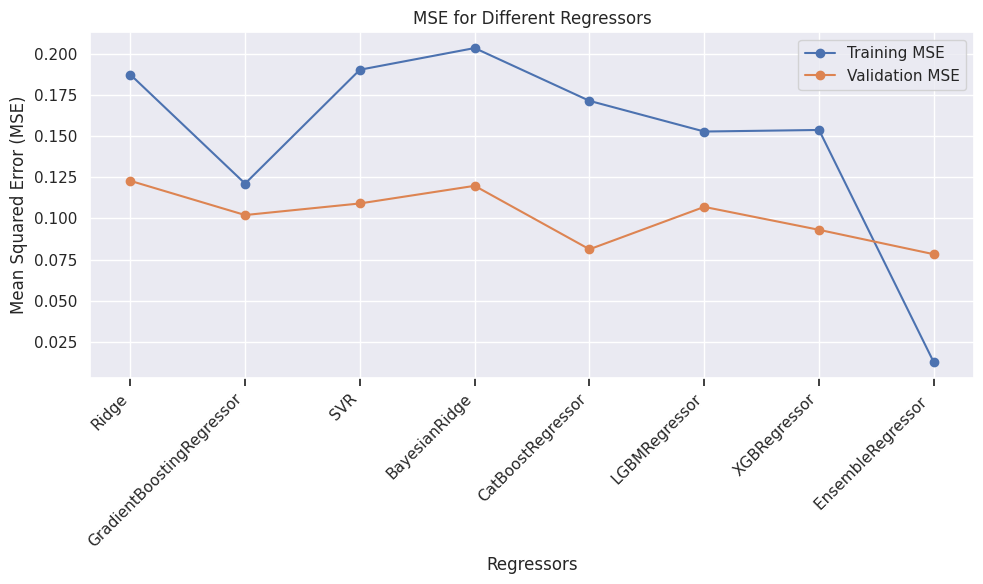

In [47]:
regressor_names = regressor_names + ['EnsembleRegressor ']

# Plotting
plt.figure(figsize=(10, 6))

# Plot training MSE
plt.plot(range(len(regressor_names)), train_mse, label='Training MSE', marker='o')

# Plot validation MSE
plt.plot(range(len(regressor_names)), val_mse, label='Validation MSE', marker='o')

# Set x-axis labels as regressor names

plt.xticks(range(len(regressor_names)), regressor_names, rotation=45, ha='right')

# Add labels and title
plt.xlabel('Regressors')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Different Regressors')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [48]:
X = np.concatenate([X_train, X_val])
y = np.concatenate([y_train, y_val])

Ridge_best_params.fit(X, y)
GradientBoostingRegressor_best_params.fit(X, y)
SVR_best_params.fit(X, y)
BayesianRidge_best_params.fit(X, y)
CatBoostRegressor_best_params.fit(X, y)
LGBMRegressor_best_params.fit(X, y)
XGB_best_params.fit(X, y)
stack_gen.fit(X, y)

y_pred_scaled = blended_predictions(X)

y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

In [49]:
y_pred_scaled = blended_predictions(X_test)

y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

In [50]:
df_Id["SalePrice"] = y_pred
df_Id.drop(columns="index", axis=1, inplace = True)
df_Id

,Id,SalePrice
0,1461,123994.031795
1,1462,159185.764831
2,1463,186667.463793
3,1464,189286.748605
4,1465,182498.990337
...,...,...
1454,2915,86404.712401
1455,2916,81038.773519
1456,2917,167739.892452
1457,2918,119187.823958


In [51]:
df_Id.to_csv("submission.csv", index=False)